In [1]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
import utils, hf
from scipy.optimize import anderson
from tqdm import tqdm

s0 = np.identity(2)
sz = np.diag([1, -1])

norbs=2

graphene = kwant.lattice.general(
    [[1, 0], [1 / 2, np.sqrt(3) / 2]], [[0, 0], [0, 1 / np.sqrt(3)]],
    norbs=norbs
)
a, b = graphene.sublattices

# create bulk system
bulk_graphene = kwant.Builder(kwant.TranslationalSymmetry(*graphene.prim_vecs))
# add sublattice potential
m0 = 0
bulk_graphene[a.shape((lambda pos: True), (0, 0))] = m0 * sz
bulk_graphene[b.shape((lambda pos: True), (0, 0))] = -m0 * sz
# add hoppings between sublattices
bulk_graphene[graphene.neighbors(1)] = s0

# use kwant wraparound to sample bulk k-space
wrapped_syst = kwant.wraparound.wraparound(bulk_graphene)
wrapped_fsyst = kwant.wraparound.wraparound(bulk_graphene).finalized()

In [2]:
def func_onsite(site, U):
    return U * np.ones((2, 2))

def func_hop(site1, site2, V):
    rij = np.linalg.norm(site1.pos - site2.pos)
    return V * np.ones((2, 2))

def calculate_Hint(U, V, Uk, Vk):
    return U * Uk + V * Vk

In [3]:
Us = np.linspace(1e-6, 5, 10)
Vs = np.linspace(1e-6, 5, 10)

In [6]:
dummy_syst, deltas = utils.generate_scf_syst(
    max_neighbor=1, syst=wrapped_syst, lattice=graphene
)

deltas = np.asarray(deltas)
deltas = np.unique(np.stack([*deltas, *-deltas]), axis=(0))


def compute_gap(
    U,
    V,
    H_int,
    max_neighbor=1,
    lattice=graphene,
    filling=2,
    nk=12,
    tol=1e-5,
    norbs=norbs,
    nk_dense=60,
    mixing=0.5,
    order=1,
):
    # Generate coarse-grid k-points
    ks, dk = np.linspace(0, 2 * np.pi, nk, endpoint=False, retstep=True)
    # Generate Hamiltonian on a k-point grid
    hamiltonians_0 = utils.syst2hamiltonian(kxs=ks, kys=ks, syst=wrapped_fsyst)
    # Generate guess on the same grid
    guess = utils.generate_guess(max_neighbor, norbs, lattice, ks, ks, dummy_syst)
    # Find groundstate Hamiltonian on the same grid
    hk = hf.find_groundstate_ham(
        H_int=H_int,
        nk=nk,
        filling=filling,
        hamiltonians_0=hamiltonians_0,
        tol=tol,
        guess=guess,
        mixing=mixing,
        order=order,
    )
    # Diagonalize groundstate Hamiltonian
    vals, vecs = np.linalg.eigh(hk)
    # Extract coarse-grid Fermi energy
    E_F = utils.get_fermi_energy(vals, 2)
    # Compute coarse-grid gap
    gap1 = utils.calc_gap(vals, E_F)
    # Generate kwant system with k-grid Hamiltonian
    scf_syst = utils.hk2syst(deltas, hk, ks, dk, max_neighbor, norbs, lattice)
    # Generate dense-grid k-points
    ks_dense = np.linspace(0, 2 * np.pi, nk_dense, endpoint=False)
    # Compute groundstate Hamiltonian on a dense grid
    scf_ham = utils.syst2hamiltonian(
        kxs=ks_dense, kys=ks_dense, syst=scf_syst, params={}
    )
    # Diagonalize groundstate Hamiltonian
    vals, vecs = np.linalg.eigh(scf_ham)
    # Extract dense-grid Fermi energy
    E_F = utils.get_fermi_energy(vals, 2)

    gap2 = utils.calc_gap(vals, E_F)
    return gap1, gap2


def compute_phase_diagram(Us, Vs, nk, tol, mixing, order):
    ks = np.linspace(0, 2 * np.pi, nk, endpoint=False)

    Uk = utils.potential2hamiltonian(
        syst=wrapped_syst,
        lattice=graphene,
        func_onsite=func_onsite,
        func_hop=func_hop,
        params=dict(U=1, V=0),
        ks=ks,
    )

    Vk = utils.potential2hamiltonian(
        syst=wrapped_syst,
        lattice=graphene,
        func_onsite=func_onsite,
        func_hop=func_hop,
        params=dict(U=0, V=1),
        ks=ks,
    )
    gap = []
    for U in tqdm(Us):
        gap_U = []
        for V in Vs:
            H_int = calculate_Hint(U, V, Uk, Vk)
            gap_U.append(
                compute_gap(
                    U=U, V=V, H_int=H_int, nk=nk, tol=tol, mixing=mixing, order=order
                )
            )
        gap.append(gap_U)
    return np.asarray(gap, dtype=float)

In [8]:
gap = compute_phase_diagram(Us, Vs, nk=3, tol=1e-10, mixing=0.1, order=3)

100%|██████████| 10/10 [02:05<00:00, 12.58s/it]


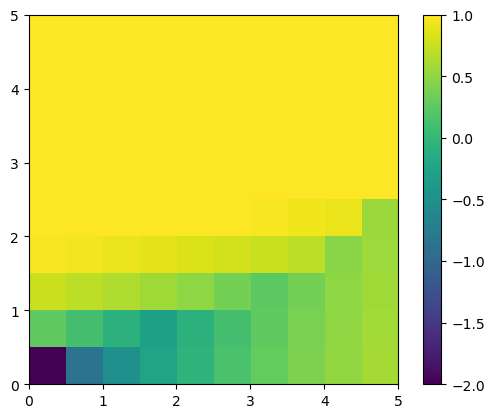

In [13]:
plt.imshow(np.log10(gap[:,:,0]).T, origin='lower', extent=(0, 5, 0, 5), vmin=-2, vmax=1)
plt.colorbar()

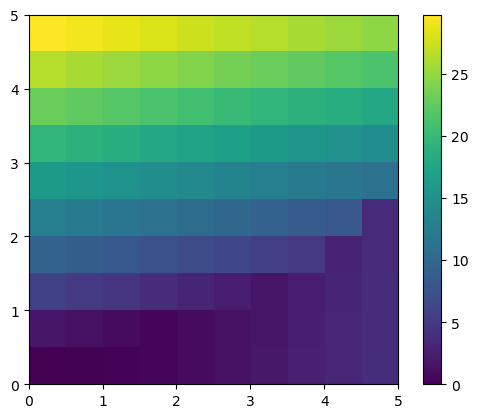

In [14]:
plt.imshow((gap[:,:,0]).T, origin='lower', extent=(0, 5, 0, 5), vmin=0)
plt.colorbar()

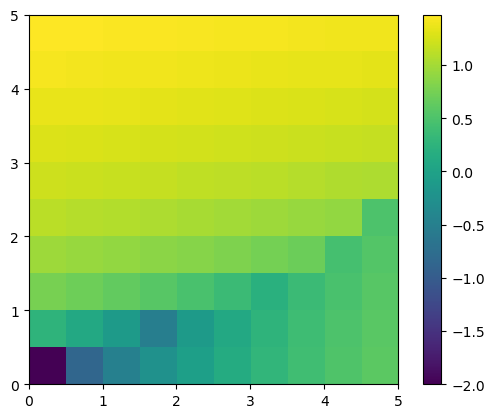

In [15]:
gap = np.asarray(gap, dtype=float)
plt.imshow(np.log10(gap[:,:,1]).T, origin='lower', extent=(0, 5, 0, 5), vmin=-2)
plt.colorbar()

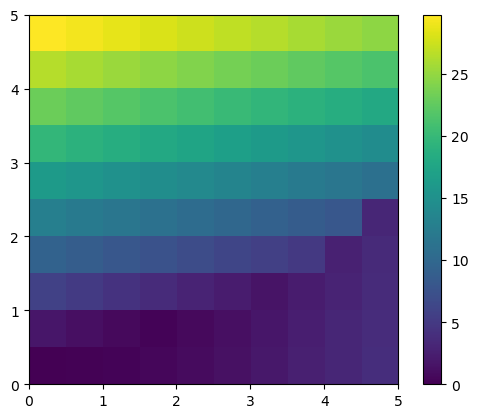

In [16]:
gap = np.asarray(gap, dtype=float)
plt.imshow((gap[:,:,1]).T, origin='lower', extent=(0, 5, 0, 5), vmin=0)
plt.colorbar()